# **Three Drivers, One Season: A Data-Driven Picture of Lando, Max and Oscar’s Battle**

In [1]:
!pip install requests pandas matplotlib

To fetch the data, I wrote a small helper function that sends a request to the OpenF1 API (https://openf1.org) and returns the results as a pandas DataFrame.

In [2]:
import requests
import pandas as pd

BASE = "https://api.openf1.org/v1"

def get_openf1(endpoint: str, **params) -> pd.DataFrame:
    """
    Generic helper to call OpenF1 and return a DataFrame.
    Example: get_openf1("sessions", year=2025, session_name="Race")
    """
    url = f"{BASE}/{endpoint}"
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    return pd.DataFrame(data)

In [3]:
# Test the helper to check for correctness
sessions_2023_sg = get_openf1("meetings", year=2023, country_name="Singapore")
sessions_2023_sg.head()

,meeting_key,circuit_key,circuit_short_name,meeting_code,location,country_key,country_code,country_name,meeting_name,meeting_official_name,gmt_offset,date_start,year
0,1219,61,Singapore,SGP,Marina Bay,157,SGP,Singapore,Singapore Grand Prix,FORMULA 1 SINGAPORE AIRLINES SINGAPORE GRAND P...,08:00:00,2023-09-15T09:30:00+00:00,2023


In [4]:
# Pull all race sessions in 2025
sessions_2025_race = get_openf1("sessions", year=2025, session_name="Race")
sessions_2025_race[["meeting_key", "session_key", "country_name", "location", "date_start"]].head()

,meeting_key,session_key,country_name,location,date_start
0,1254,9693,Australia,Melbourne,2025-03-16T04:00:00+00:00
1,1255,9998,China,Shanghai,2025-03-23T07:00:00+00:00
2,1256,10006,Japan,Suzuka,2025-04-06T05:00:00+00:00
3,1257,10014,Bahrain,Sakhir,2025-04-13T15:00:00+00:00
4,1258,10022,Saudi Arabia,Jeddah,2025-04-20T17:00:00+00:00


In [5]:
def get_dInfo(session_key):
    return get_openf1("drivers", session_key=session_key)

drivers_example = get_dInfo(sessions_2025_race.session_key.iloc[0])
print(drivers_example[["driver_number", "full_name", "name_acronym", "team_name"]])

# Setup the 3 drivers - Max, Lando, Oscar

DRIVERS = {
    "VER": 1,   # Max Verstappen
    "NOR": 4,   # Lando Norris
    "PIA": 81,  # Oscar Piastri
}

    driver_number              full_name name_acronym        team_name
0               1         Max VERSTAPPEN          VER  Red Bull Racing
1               4           Lando NORRIS          NOR          McLaren
2               5      Gabriel BORTOLETO          BOR      Kick Sauber
3               6           Isack HADJAR          HAD     Racing Bulls
4               7            Jack DOOHAN          DOO           Alpine
5              10           Pierre GASLY          GAS           Alpine
6              12  Andrea Kimi ANTONELLI          ANT         Mercedes
7              14        Fernando ALONSO          ALO     Aston Martin
8              16        Charles LECLERC          LEC          Ferrari
9              18           Lance STROLL          STR     Aston Martin
10             22           Yuki TSUNODA          TSU     Racing Bulls
11             23        Alexander ALBON          ALB         Williams
12             27        Nico HULKENBERG          HUL      Kick Sauber
13    

In [6]:
# Test race data to check for correctness

# Take the last race in the season (must be Qatar)
race = sessions_2025_race.sort_values("date_start").iloc[-1]
race_session_key = int(race["session_key"])
print(race[["meeting_key", "country_name", "location", "date_start"]])

def get_laps(session_key, driver_number):
    return get_openf1("laps", session_key=session_key, driver_number=driver_number)

laps = {code: get_laps(race_session_key, num) for code, num in DRIVERS.items()}

for code, df in laps.items():
    print(code, df.shape)

meeting_key                          1275
country_name                        Qatar
location                           Lusail
date_start      2025-11-30T16:00:00+00:00
Name: 22, dtype: object
VER (57, 16)
NOR (57, 16)
PIA (57, 16)


Before calculating race pace, it's best to clean the raw lap data. The OpenF1 laps endpoint includes a column called is_pit_out_lap, which marks laps where the driver is leaving the pit lane. These laps are always much slower because of the pit limiter and cold tyres, so including them would distort the true race pace.

In [7]:
def removePitOut(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["lap_time_s"] = df["lap_duration"]

    # Remove pit-out laps or invalid laps if needed
    if "is_pit_out_lap" in df.columns:
        df = df[~df["is_pit_out_lap"]]
    return df

wOut = {code: removePitOut(df) for code, df in laps.items()}

for code, df in wOut.items():
    print(
        code,
        "laps:", df["lap_number"].nunique(),
        "avg:", df["lap_time_s"].mean(),
        "std:", df["lap_time_s"].std()
    )

VER laps: 55 avg: 87.7161296296296 std: 10.674799862992964
NOR laps: 55 avg: 88.82883333333336 std: 13.221195100192666
PIA laps: 55 avg: 88.60035185185183 std: 13.689112499530706


Now that everything is working smoothly, we can start the actual analysis by pulling all the data we need from the OpenF1 API.

In [8]:
# Get all race sessions
sessions_2025 = get_openf1("sessions", year=2025, session_name="Race")

# Get meeting names (Grand Prix names)
meetings_2025 = get_openf1("meetings", year=2025)

# Merge on meeting_key to add meeting_name + location
all_2025 = sessions_2025.merge(
    meetings_2025[["meeting_key", "meeting_name", "location"]],
    on="meeting_key",
    how="left"
)

# Sort chronologically
all_2025 = all_2025.sort_values("date_start").reset_index(drop=True)

all_2025[["year", "meeting_name", "location_x", "session_key"]].head()

,year,meeting_name,location_x,session_key
0,2025,Australian Grand Prix,Melbourne,9693
1,2025,Chinese Grand Prix,Shanghai,9998
2,2025,Japanese Grand Prix,Suzuka,10006
3,2025,Bahrain Grand Prix,Sakhir,10014
4,2025,Saudi Arabian Grand Prix,Jeddah,10022


**Pace from Lap Data**

We summarize each driver’s performance using three simple statistics: the number of valid race laps they completed, their average lap time, and the standard deviation of those lap times (which gives an approximate idea of consistency).

In [9]:
def analyze_race_pace(session_row: pd.Series) -> pd.DataFrame:
    session_key = int(session_row["session_key"])

    # laps for each driver
    laps = {}
    for code, num in DRIVERS.items():
        df = get_openf1("laps", session_key=session_key, driver_number=num)
        if df.empty:
            continue
        laps[code] = df

    if not laps:
        return pd.DataFrame()

    # Clean laps
    clean = {code: removePitOut(df) for code, df in laps.items()}

    # Race-level summary
    rows = []
    for code, df in clean.items():
        if df.empty:
            continue

        rows.append({
            "year": session_row["year"],
            "meeting_name": session_row["meeting_name"],
            "location": session_row["location_x"],
            "session_key": session_key,
            "driver": code,
            "n_laps": df["lap_number"].nunique(),
            "avg_lap_s": df["lap_time_s"].mean(),
            "std_lap_s": df["lap_time_s"].std(),
        })
    return pd.DataFrame(rows)

In [10]:
race_summaries = []

for _, row in all_2025.iterrows():
    try:
        df = analyze_race_pace(row)
        if not df.empty:
            race_summaries.append(df)
    except Exception as e:
        print("Error in", row["meeting_name"], ":", e)

season_race_pace = pd.concat(race_summaries, ignore_index=True)
season_race_pace.head()

,year,meeting_name,location,session_key,driver,n_laps,avg_lap_s,std_lap_s
0,2025,Australian Grand Prix,Melbourne,9693,VER,52,103.814843,22.688352
1,2025,Australian Grand Prix,Melbourne,9693,NOR,53,104.469137,23.514918
2,2025,Australian Grand Prix,Melbourne,9693,PIA,52,104.760647,24.557854
3,2025,Chinese Grand Prix,Shanghai,9998,VER,55,97.299648,1.274513
4,2025,Chinese Grand Prix,Shanghai,9998,NOR,55,97.219426,1.253563


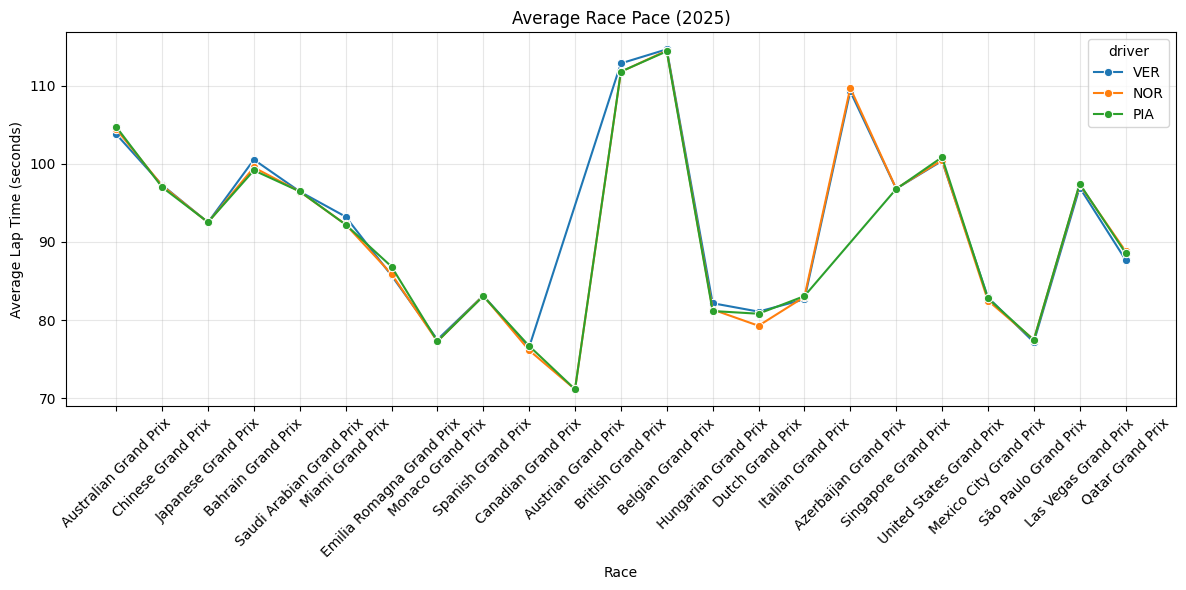

In [11]:
# Plot average race pace

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=season_race_pace,
    x="meeting_name",
    y="avg_lap_s",
    hue="driver",
    marker="o"
)

plt.title("Average Race Pace (2025)")
plt.ylabel("Average Lap Time (seconds)")
plt.xlabel("Race")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

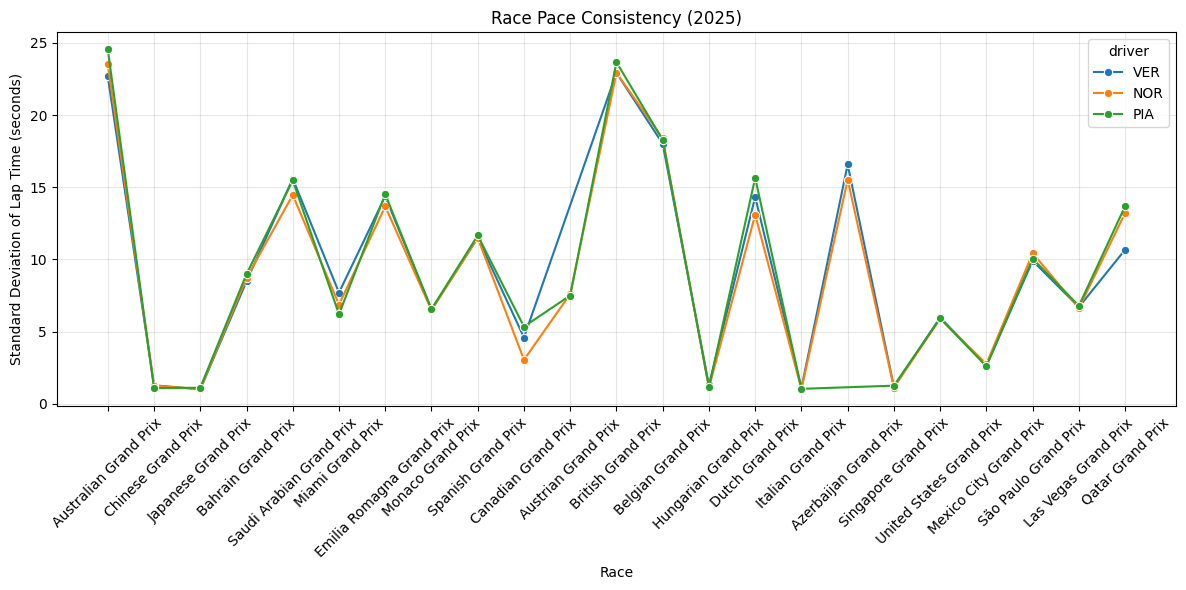

In [12]:
# Plot race consistency (standard deviation - race pace)

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=season_race_pace,
    x="meeting_name",
    y="std_lap_s",
    hue="driver",
    marker="o"
)

plt.title("Race Pace Consistency (2025)")
plt.ylabel("Standard Deviation of Lap Time (seconds)")
plt.xlabel("Race")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Season-Level Summary and Pivot Table**

In [13]:
season_avg_pace = (
    season_race_pace
    .groupby("driver")
    .agg(
        races=("meeting_name", "nunique"),
        avg_lap_s=("avg_lap_s", "mean"),
        avg_std_lap_s=("std_lap_s", "mean")
    )
    .reset_index()
)

season_avg_pace

,driver,races,avg_lap_s,avg_std_lap_s
0,NOR,23,91.265319,9.136638
1,PIA,23,90.564134,9.227371
2,VER,23,92.341548,9.317776


In [14]:
# Pivot into one row per race, columns for each driver's avg pace
race_pace_pivot = (
    season_race_pace
    .pivot_table(
        index=["year", "meeting_name", "location"],
        columns="driver",
        values="avg_lap_s"
    )
    .reset_index()
)

race_pace_pivot.head()

driver,year,meeting_name,location,NOR,PIA,VER
0,2025,Australian Grand Prix,Melbourne,104.469137,104.760647,103.814843
1,2025,Austrian Grand Prix,Spielberg,71.117791,71.120090,NaN
2,2025,Azerbaijan Grand Prix,Baku,109.735184,NaN,109.310245
3,2025,Bahrain Grand Prix,Sakhir,99.552389,99.181778,100.555370
4,2025,Belgian Grand Prix,Spa-Francorchamps,114.535262,114.445690,114.696952


**Pace Delta vs Lando Norris**

To make the comparison easier, we calculate the pace difference for Max and Oscar relative to Lando. Since Lando has been consistently fast for most of the season, we use his average lap time as the baseline. The difference is computed in milliseconds per lap, which gives a clear sense of how much quicker or slower each driver was at every race.

In [15]:
for drv in ["VER", "PIA"]:
    race_pace_pivot[f"{drv}_vs_NOR_ms"] = (race_pace_pivot[drv] - race_pace_pivot["NOR"]) * 1000

race_pace_pivot[["meeting_name", "location", "NOR", "VER_vs_NOR_ms", "PIA_vs_NOR_ms"]].head()

driver,meeting_name,location,NOR,VER_vs_NOR_ms,PIA_vs_NOR_ms
0,Australian Grand Prix,Melbourne,104.469137,-654.294118,291.509804
1,Austrian Grand Prix,Spielberg,71.117791,NaN,2.298507
2,Azerbaijan Grand Prix,Baku,109.735184,-424.938776,NaN
3,Bahrain Grand Prix,Sakhir,99.552389,1002.981481,-370.611111
4,Belgian Grand Prix,Spa-Francorchamps,114.535262,161.690476,-89.571429


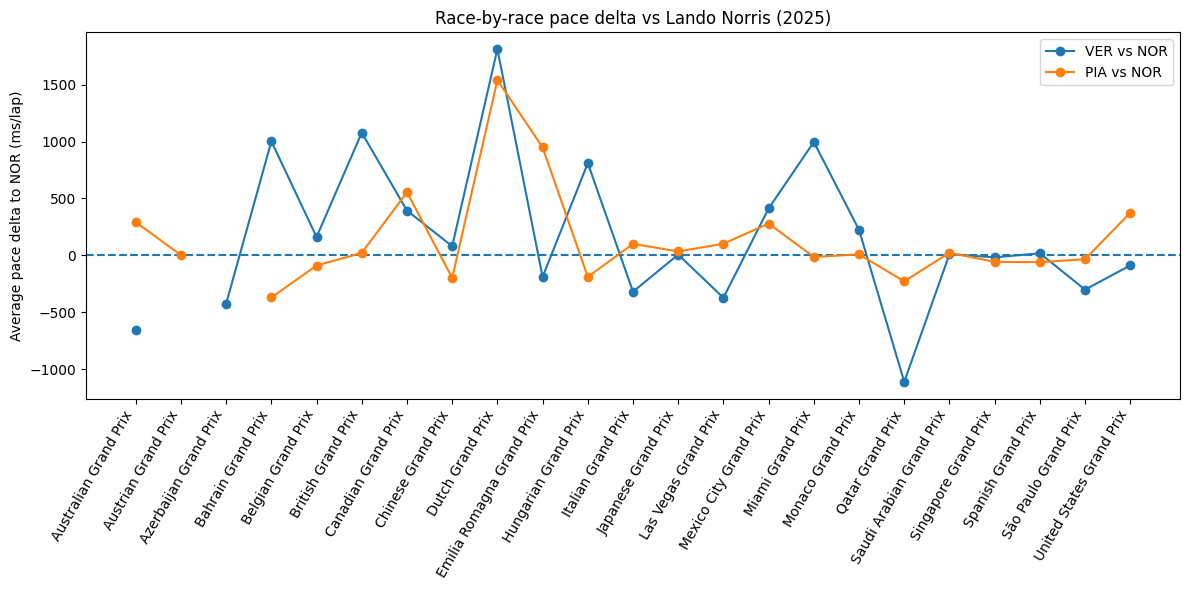

In [16]:
# Plot race delta

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

x = range(len(race_pace_pivot))

plt.axhline(0, linestyle="--")  # NOR baseline

plt.plot(x, race_pace_pivot["VER_vs_NOR_ms"], marker="o", label="VER vs NOR")
plt.plot(x, race_pace_pivot["PIA_vs_NOR_ms"], marker="o", label="PIA vs NOR")

plt.xticks(x, race_pace_pivot["meeting_name"], rotation=60, ha="right")
plt.ylabel("Average pace delta to NOR (ms/lap)")
plt.title("Race-by-race pace delta vs Lando Norris (2025)")
plt.legend()
plt.tight_layout()
plt.show()

**Stints Profile for Each Driver**

We summarize each race stint by matching the lap range to the driver’s lap data, cleaning it, and computing stint length, average pace, and total degradation.

In [17]:
def summarize_race_stints(session_row: pd.Series) -> pd.DataFrame:
    session_key = int(session_row["session_key"])
    meeting_name = session_row["meeting_name"]
    location = session_row["location_x"]
    year = session_row["year"]

    rows = []

    for code, num in DRIVERS.items():
        # Stints and laps
        stints = get_openf1("stints", session_key=session_key, driver_number=num)
        laps = get_openf1("laps", session_key=session_key, driver_number=num)

        if stints.empty or laps.empty:
            continue

        # Clean laps
        laps = removePitOut(laps)

        for _, stint in stints.iterrows():
            mask = (
                (laps["lap_number"] >= stint["lap_start"]) &
                (laps["lap_number"] <= stint["lap_end"])
            )
            seg = laps[mask].copy()
            if seg.empty:
                continue

            # Sort laps
            seg = seg.sort_values("lap_number")

            # Degradation
            if len(seg) >= 2:
                deg_total_s = seg["lap_time_s"].iloc[-1] - seg["lap_time_s"].iloc[0]
            else:
                deg_total_s = None

            rows.append({
                "year": year,
                "meeting_name": meeting_name,
                "location": location,
                "driver": code,
                "compound": stint["compound"],
                "stint_number": stint["stint_number"],
                "lap_start": stint["lap_start"],
                "lap_end": stint["lap_end"],
                "stint_laps": len(seg),
                "avg_lap_s": seg["lap_time_s"].mean(),
                "deg_total_s": deg_total_s,
            })

    return pd.DataFrame(rows)

In [19]:
stint_summaries = []

for _, row in all_2025.iterrows():
    df = summarize_race_stints(row)
    if not df.empty:
        stint_summaries.append(df)

season_stints = pd.concat(stint_summaries, ignore_index=True)
season_stints.head()

,year,meeting_name,location,driver,compound,stint_number,lap_start,lap_end,stint_laps,avg_lap_s,deg_total_s
0,2025,Australian Grand Prix,Melbourne,VER,INTERMEDIATE,1,1,2,2,169.322000,NaN
1,2025,Australian Grand Prix,Melbourne,VER,INTERMEDIATE,2,2,3,1,169.322000,NaN
2,2025,Australian Grand Prix,Melbourne,VER,INTERMEDIATE,4,4,34,29,95.527172,-11.056
3,2025,Australian Grand Prix,Melbourne,VER,MEDIUM,5,34,46,12,116.883417,-15.992
4,2025,Australian Grand Prix,Melbourne,VER,INTERMEDIATE,6,46,57,11,108.504545,-25.206


We aggregate all stint-level data by driver and compound to compute the average stint length, average pace, total degradation, and number of stints for each tyre type.

In [20]:
tyre_profile = (
    season_stints
    .groupby(["driver", "compound"])
    .agg(
        n_stints=("stint_number", "count"),
        avg_stint_laps=("stint_laps", "mean"),
        avg_pace_s=("avg_lap_s", "mean"),
        avg_degradation_s=("deg_total_s", "mean")
    )
    .reset_index()
)

tyre_profile

,driver,compound,n_stints,avg_stint_laps,avg_pace_s,avg_degradation_s
0,NOR,HARD,21,24.523810,91.540896,-14.344737
1,NOR,INTERMEDIATE,7,12.714286,129.115245,-15.771000
2,NOR,MEDIUM,25,23.280000,88.139682,-1.590909
3,NOR,SOFT,8,15.750000,86.724255,-5.627200
4,PIA,HARD,19,25.947368,87.197815,-4.501842
5,PIA,INTERMEDIATE,7,12.571429,129.268549,-41.506667
6,PIA,MEDIUM,27,20.333333,90.170640,-6.751818
7,PIA,SOFT,9,14.555556,90.548381,-5.737600
8,VER,HARD,20,23.350000,90.950338,-10.203563
9,VER,INTERMEDIATE,7,12.000000,129.740604,-16.007000


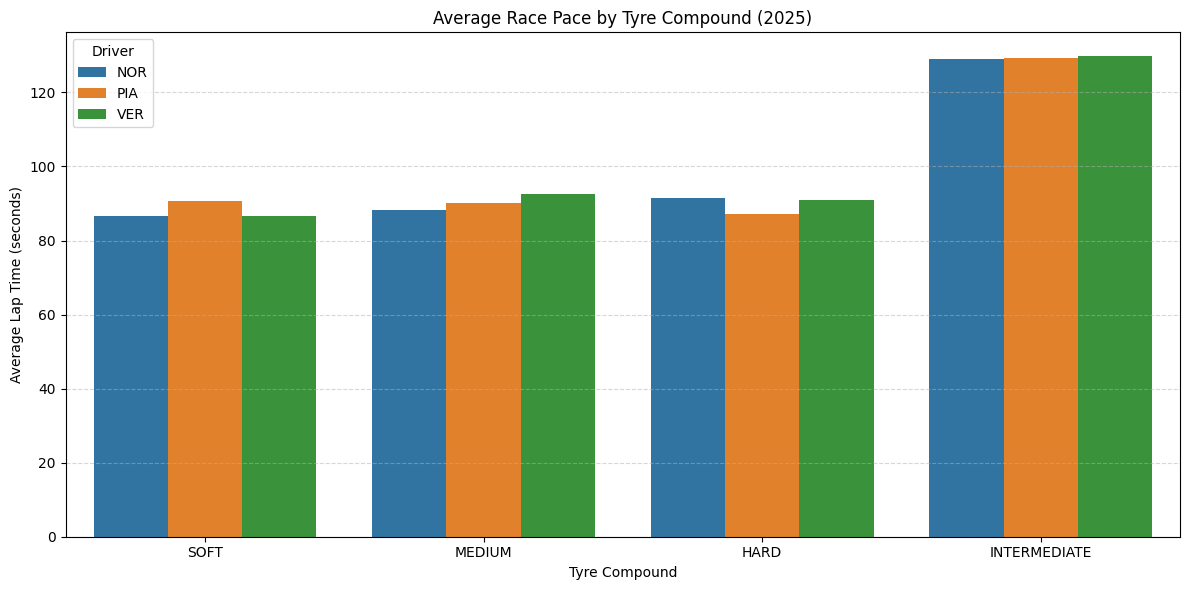

In [21]:
# Plot race pace vs tyre compound

import matplotlib.pyplot as plt
import seaborn as sns

df_plot = tyre_profile.copy()

compound_order = ["SOFT", "MEDIUM", "HARD", "INTERMEDIATE"]
df_plot["compound"] = pd.Categorical(df_plot["compound"], compound_order)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot,
    x="compound",
    y="avg_pace_s",
    hue="driver"
)

plt.title("Average Race Pace by Tyre Compound (2025)")
plt.ylabel("Average Lap Time (seconds)")
plt.xlabel("Tyre Compound")
plt.legend(title="Driver")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

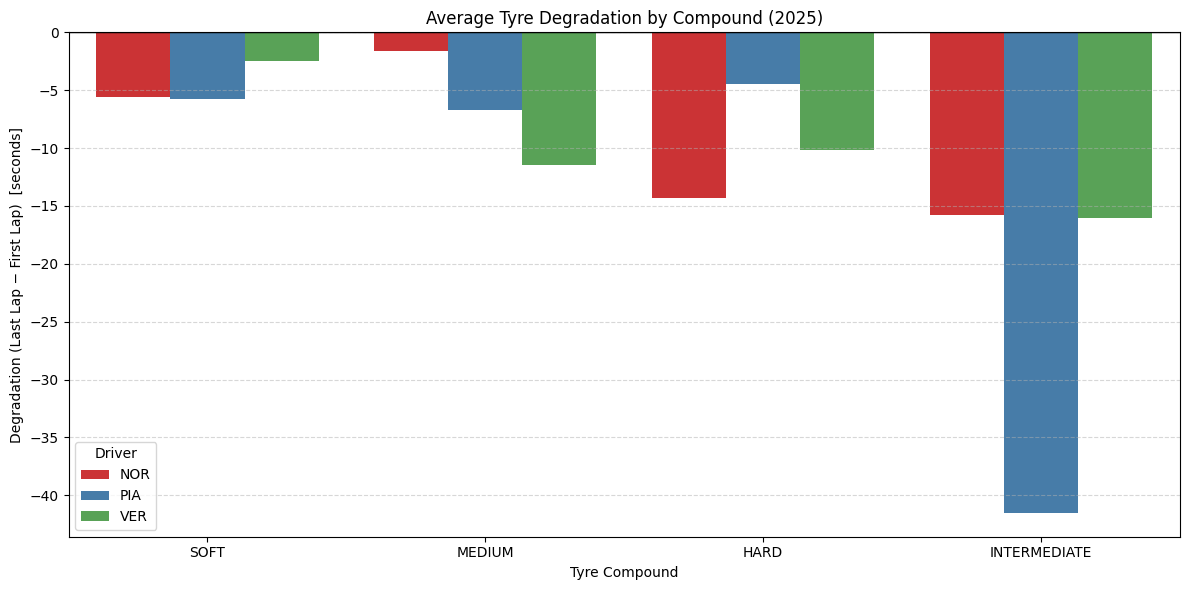

In [22]:
# Plot tyre degradation

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot,
    x="compound",
    y="avg_degradation_s",
    hue="driver",
    palette="Set1"
)

plt.title("Average Tyre Degradation by Compound (2025)")
plt.ylabel("Degradation (Last Lap − First Lap)  [seconds]")
plt.xlabel("Tyre Compound")
plt.axhline(0, color="black", linewidth=1)
plt.legend(title="Driver")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

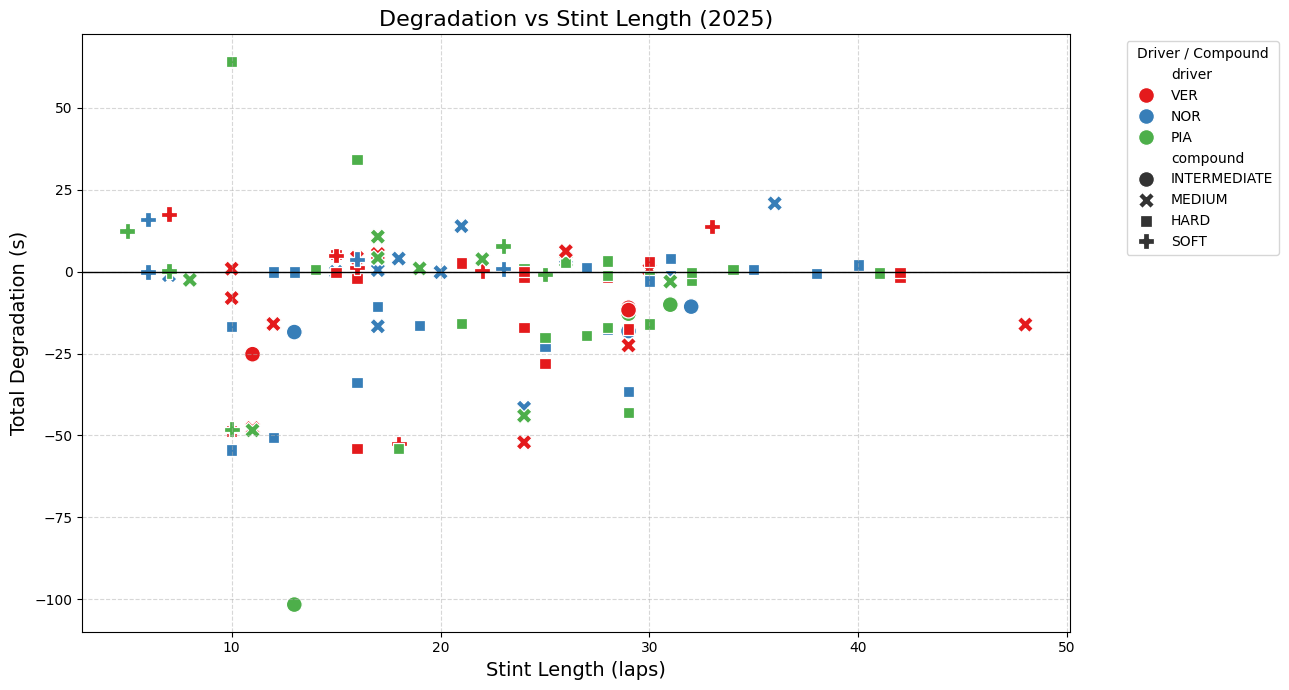

In [27]:
# Plot degradation vs stint length

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(13, 7))

sns.scatterplot(
    data=season_stints,
    x="stint_laps",
    y="deg_total_s",
    hue="driver",
    style="compound",
    s=130,
    palette="Set1"
)

plt.title("Degradation vs Stint Length (2025)", fontsize=16)
plt.xlabel("Stint Length (laps)", fontsize=14)
plt.ylabel("Total Degradation (s)", fontsize=14)

plt.axhline(0, color="black", linewidth=1)  # baseline reference
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(title="Driver / Compound", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Position Changes**

We compute each driver’s starting and finishing position for a race and calculate how many places they gained or lost. Then, we compile each driver’s position changes across all races in 2025 into a single table. Number of positions each driver gained or lost in every race is visualised using a heatmap.

In [45]:
def get_position_changes(session_key):
    pos = get_openf1("position", session_key=session_key)
    if pos.empty:
        return None

    # Keep only first and last recorded positions per driver
    first = pos.sort_values("date").groupby("driver_number").first()["position"]
    last = pos.sort_values("date").groupby("driver_number").last()["position"]

    df = pd.DataFrame({
        "start_pos": first,
        "finish_pos": last
    })
    df["pos_change"] = df["start_pos"] - df["finish_pos"]  # positive = gained

    return df

In [46]:
position_changes = {}

for _, row in all_2025.iterrows():
    pos_df = get_position_changes(row["session_key"])
    if pos_df is not None:
        position_changes[row["meeting_name"]] = pos_df

In [47]:
driver_pos_change = []

for meeting, pos_df in position_changes.items():
    for code, num in DRIVERS.items():
        if num in pos_df.index:
            driver_pos_change.append({
                "meeting": meeting,
                "driver": code,
                "pos_change": pos_df.loc[num, "pos_change"]
            })

df_pos_change = pd.DataFrame(driver_pos_change)
df_pos_change.head()

,meeting,driver,pos_change
0,Australian Grand Prix,VER,1
1,Australian Grand Prix,NOR,0
2,Australian Grand Prix,PIA,-7
3,Chinese Grand Prix,VER,0
4,Chinese Grand Prix,NOR,1


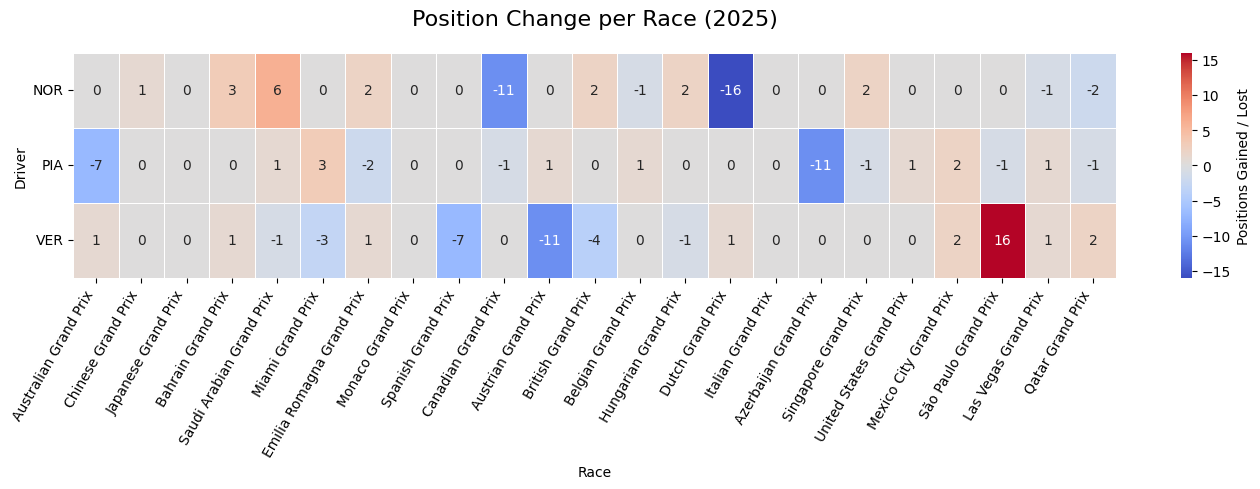

In [48]:
# Plot position changes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

race_order = df_pos_change["meeting"].unique()

pivot_df = df_pos_change.pivot(index="driver", columns="meeting", values="pos_change")

pivot_df = pivot_df[race_order]

plt.figure(figsize=(14, 5))

sns.heatmap(
    pivot_df,
    annot=True,
    center=0,
    cmap = "coolwarm",
    linewidths=0.5,
    cbar_kws={"label": "Positions Gained / Lost"}
)

plt.title("Position Change per Race (2025)", fontsize=16, pad=20)
plt.xlabel("Race")
plt.ylabel("Driver")
plt.xticks(rotation=60, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()